In [1]:
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, ElasticNet
import xgboost as xgb
import statsmodels.api as sm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
player_info_df = pd.read_csv(r'result_files/nl_100_dummies.csv').drop('Unnamed: 0', axis=1)
player_info_df

,win_per_hand,win_per_hand_involve,p_agg_aggressive,p_agg_passive,f_agg_aggressive,f_agg_passive,t_agg_aggressive,t_agg_passive,r_agg_aggressive,r_agg_passive,vpip_loose,vpip_tight,pot_size_large,pot_size_small,post_num_less,post_num_many
0,0,0,1,0,0,1,0,1,0,1,0,1,1,0,1,0
1,1,1,0,1,1,0,1,0,1,0,0,1,1,0,1,0
2,1,0,0,1,0,1,0,1,0,1,0,1,0,1,0,1
3,0,0,1,0,1,0,0,1,0,1,0,1,1,0,1,0
4,0,0,1,0,0,1,0,1,0,1,0,1,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
324,0,0,1,0,0,1,0,1,1,0,1,0,0,1,1,0
325,0,0,0,1,0,1,1,0,0,1,1,0,1,0,0,1
326,1,1,0,1,0,1,0,1,1,0,0,1,0,1,0,1
327,1,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1


In [3]:
# how many entries are different on the 2 dependent variables?
sum(player_info_df['win_per_hand'] != player_info_df['win_per_hand_involve'])

30

**There are 2 dependent variables in the data frame right now, but they are quite similar. From the above line we can see only 30 entries are different in the 2 columns. I will be analyzing win_per_hand as the dependent variable first, because I think this will be what people are more interested in while playing poker. I will explore the random forest model, logistic regression model, and gradient boosting.**

### Splitting data

In [4]:
X = player_info_df.drop(['win_per_hand', 'win_per_hand_involve'], axis=1)
y = player_info_df['win_per_hand']
X.head()

,p_agg_aggressive,p_agg_passive,f_agg_aggressive,f_agg_passive,t_agg_aggressive,t_agg_passive,r_agg_aggressive,r_agg_passive,vpip_loose,vpip_tight,pot_size_large,pot_size_small,post_num_less,post_num_many
0,1,0,0,1,0,1,0,1,0,1,1,0,1,0
1,0,1,1,0,1,0,1,0,0,1,1,0,1,0
2,0,1,0,1,0,1,0,1,0,1,0,1,0,1
3,1,0,1,0,0,1,0,1,0,1,1,0,1,0
4,1,0,0,1,0,1,0,1,0,1,0,1,1,0


#### Remove highly correlated feature columns, for example, p_agg_aggressive and p_agg_passive are the inverse of each other. 

In [5]:
X.drop(['p_agg_passive', 'f_agg_passive', 't_agg_passive', 'r_agg_passive', 'post_num_less', 'vpip_loose', 'pot_size_small'], axis=1, inplace=True)

In [6]:
X.head()

,p_agg_aggressive,f_agg_aggressive,t_agg_aggressive,r_agg_aggressive,vpip_tight,pot_size_large,post_num_many
0,1,0,0,0,1,1,0
1,0,1,1,1,1,1,0
2,0,0,0,0,1,0,1
3,1,1,0,0,1,1,0
4,1,0,0,0,1,0,0


In [51]:
X.join(y).head()

,p_agg_aggressive,f_agg_aggressive,t_agg_aggressive,r_agg_aggressive,vpip_tight,pot_size_large,post_num_many,win_per_hand
0,1,0,0,0,1,1,0,0
1,0,1,1,1,1,1,0,1
2,0,0,0,0,1,0,1,1
3,1,1,0,0,1,1,0,0
4,1,0,0,0,1,0,0,0


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

### Random forest model

In [8]:
# standard random forest model
model_rf = RandomForestClassifier()
model_rf.fit(X_train, y_train)
pred_rf = model_rf.predict(X_test)
metrics.roc_auc_score(y_test, pred_rf)

0.6464460784313726

#### Hyperparameters tunning random forest model

In [9]:
# define parameter grid, and initialize randome search
params_rf = {
    'n_estimators':[25, 50, 75, 100, 200, 400],
    'criterion':['gini', 'entropy'],
    'max_depth':[3, 6, 10, 20, None],
    'bootstrap':[True, False],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10]    
}
rf_search = RandomizedSearchCV(model_rf, param_distributions=params_rf, cv=5, n_jobs=-1)

In [10]:
# fit the search object  to training data
rf_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [11]:
# examine best parameters
rf_search.best_params_

{'n_estimators': 200,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': 20,
 'criterion': 'gini',
 'bootstrap': True}

#### Creating random forest model with tunned hyperparameters

In [12]:
# unpack the values of params to different variables
n_est, min_split, min_leaf, max_feat, max_dep, crit, boot = rf_search.best_params_.values()

In [13]:
# fit the random forest model with tunned paramenters and evaluate performance
model_rf = RandomForestClassifier(
    n_estimators=n_est, 
    max_depth=max_dep, 
    criterion=crit, 
    min_samples_split=min_split, 
    min_samples_leaf=min_leaf, 
    max_features=max_feat, 
    bootstrap=boot,)
model_rf.fit(X_train, y_train)
pred_rf = model_rf.predict(X_test)
rf_score = metrics.roc_auc_score(y_test, pred_rf)
rf_score

0.6366421568627452

### Logistic regression model

In [14]:
# standard logistic regression model
model_log = LogisticRegression()
model_log.fit(X_train, y_train)
pred_log = model_log.predict(X_test)
metrics.roc_auc_score(y_test, pred_log)

0.6770833333333335

In [15]:
# create a summary table with statsmodels logistic regression
model_log_sm = sm.Logit(y_train, X_train).fit()
model_log_sm.summary()

Optimization terminated successfully.
         Current function value: 0.506739
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           win_per_hand   No. Observations:                  230
Model:                          Logit   Df Residuals:                      223
Method:                           MLE   Df Model:                            6
Date:                Thu, 17 Dec 2020   Pseudo R-squ.:                  0.2688
Time:                        22:33:28   Log-Likelihood:                -116.55
converged:                       True   LL-Null:                       -159.39
Covariance Type:            nonrobust   LLR p-value:                 2.388e-16
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
p_agg_aggressive    -1.3099      0.348     -3.760      0.000      -1.993      -0.627
f_agg_aggressive    -1.1274      0.376     -2.998      0.003      -1.865      -0.390
t_agg_aggressive    -0.7371      0.382     -1.927      0.054      -1.487       0.013
r_agg_aggressive     0.2790      0.356      0.784      0.433      -0.418       0.976
vpip_tight           0.6951      0.311      2.237      0.025       0.086       1.304
pot_size_large       1.4814      0.349      4.249      0.000       0.798       2.165
post_num_many        0.5186      0.345      1.505      0.132      -0.157       1.194
====================================================================================
"""

In [16]:
# predict the probability of outcome, and then round it to produce outcome
pred_log_sm = list(map(round, model_log_sm.predict(X_test)))
# evaluate the model
metrics.roc_auc_score(y_test, pred_log_sm)

0.6770833333333335

#### Hyperparameters tunning logistic regression model

In [17]:
# define hyperparameter grid and initialize grid search
params_log = {
    'penalty':['l1', 'l2', 'none', 'elasticnet'],
    'C':[0.000001, 0.00001, 0.0001, 0.001, 0.1, 1.0]
}
log_search = GridSearchCV(model_log, param_grid=params_log, cv=5, n_jobs=-1)

In [18]:
# fit the search object to the training data
log_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [1e-06, 1e-05, 0.0001, 0.001, 0.1, 1.0],
                         'penalty': ['l1', 'l2', 'none', 'elasticnet']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [19]:
# examine best parameters
log_search.best_params_

{'C': 0.1, 'penalty': 'l2'}

#### Creating logistic regression model with tunned hyperparameters

In [20]:
# unpack best params for best model
C, pen = log_search.best_params_.values()

In [21]:
# build model according to the best parameters and evaluate performance
model_log = LogisticRegression(penalty=pen, C=C)
model_log.fit(X_train, y_train)
pred_log = model_log.predict(X_test)
log_score = metrics.roc_auc_score(y_test, pred_log)
log_score

0.6856617647058824

### Gradient boost model with XGboost

In [22]:
# standard gradient boosting model with XGboost
model_XG = xgb.XGBClassifier()
model_XG.fit(X_train, y_train)
pred_XG = model_XG.predict(X_test)
metrics.roc_auc_score(y_test, pred_XG)

0.6464460784313726

#### hyperparameter tunning for gradient boost model

In [23]:
# create d-matrix
dtrain = xgb.DMatrix(data=X_train, label=y_train)
dtext = xgb.DMatrix(data=X_test, label=y_test)

In [24]:
params_XG = {
    'colsample_bytree':[0.4, 0.6, 0.8, 1.0],
    'learning_rate':[0.1, 0.01, 0.001, 0.0001],
    'max_depth':[5, 10, 15, None],
    'subsample':[0.4, 0.6, 0.8, 1.0],
}
search_XG = RandomizedSearchCV(model_XG, param_distributions=params_XG, cv=5, n_jobs=-1)

In [25]:
# fit the search object to the training data
search_XG.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           gpu_id=-1, importance_type='gain',
                                           interaction_constraints='',
                                           learning_rate=0.300000012,
                                           max_delta_step=0, max_depth=6,
                                           min_child_weight=1, missing=nan,
                                           monotone_constraints='()',
                                           n_estimators=100...
                                           subsample=1, tree_method='exact',
                                           validate_parameters=1,
                                     

In [26]:
# observe the best hyperparameters
search_XG.best_params_

{'subsample': 0.6,
 'max_depth': 10,
 'learning_rate': 0.1,
 'colsample_bytree': 0.8}

#### Build the gradient boost model with best hyperparameters

In [27]:
# define the best hyperparameters
subs, max_dep, eta, cols = search_XG.best_params_.values()

In [28]:
# build and evaluat the gradient boost model with best hyperparameters
model_XG = xgb.XGBClassifier(
    subsample=subs, 
    max_depth=max_dep, 
    learning_rate=eta,
    colsample_bytree=cols
)
model_XG.fit(X_train,y_train)
pred_XG = model_XG.predict(X_test)
XG_score = metrics.roc_auc_score(y_test, pred_XG)
XG_score

0.6250000000000001

### Comparing tunned models

#### Cross validation scores on training data

In [29]:
# examine the cross validation roc_auc score on the training data
cv_scores_rf = cross_val_score(model_rf, X_train, y_train, cv=5, scoring='roc_auc').mean()
cv_scores_log = cross_val_score(model_log, X_train, y_train, cv=5, scoring='roc_auc').mean()
cv_scores_XG = cross_val_score(model_XG, X_train, y_train, cv=5, scoring='roc_auc').mean()
models = ['random forest', 'logistic regression', 'gradient boosting']
scores = [cv_scores_rf, cv_scores_log, cv_scores_XG]
scores_comp = pd.DataFrame([models, scores]).T
scores_comp.columns = ['model', 'training score']
scores_comp

,model,training score
0,random forest,0.79533
1,logistic regression,0.810844
2,gradient boosting,0.779065


#### ROC_AUC scores on test data

In [30]:
# examine the scores from previous sections for each model
scores_t = [rf_score, log_score, XG_score]
scores_comp_t = pd.DataFrame([models, scores_t]).T
scores_comp_t.columns = ['model', 'test score']
scores_comp_t


,model,test score
0,random forest,0.636642
1,logistic regression,0.685662
2,gradient boosting,0.625


#### ROC curves on test data

In [31]:
# define true positive and false positive rates for each model
rf_pred_prob = model_rf.predict_proba(X_test)[:,1]
fpr_rf, tpr_rf, thresholds_rf = metrics.roc_curve(y_test, rf_pred_prob)
log_pred_prob = model_log.predict_proba(X_test)[:,1]
fpr_log, tpr_log, thresholds_log = metrics.roc_curve(y_test, log_pred_prob)
XG_pred_prob = model_XG.predict_proba(X_test)[:,1]
fpr_XG, tpr_XG, thresholds_XG = metrics.roc_curve(y_test, XG_pred_prob)

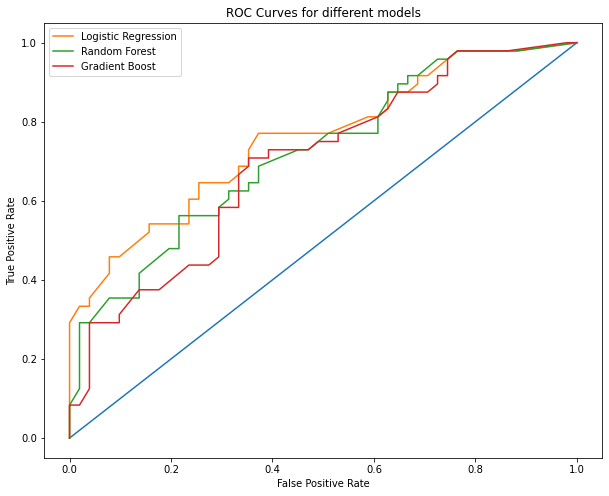

In [32]:
# plot the ROC curves on the same graph
plt.figure(figsize=(10,8))
plt.plot([0,1], [0,1])
plt.plot(fpr_log, tpr_log, label='Logistic Regression')
plt.plot(fpr_rf, tpr_rf, label='Random Forest')
plt.plot(fpr_XG, tpr_XG, label='Gradient Boost')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for different models')
plt.legend()

#### Plot the confusion matricies for all 3 models

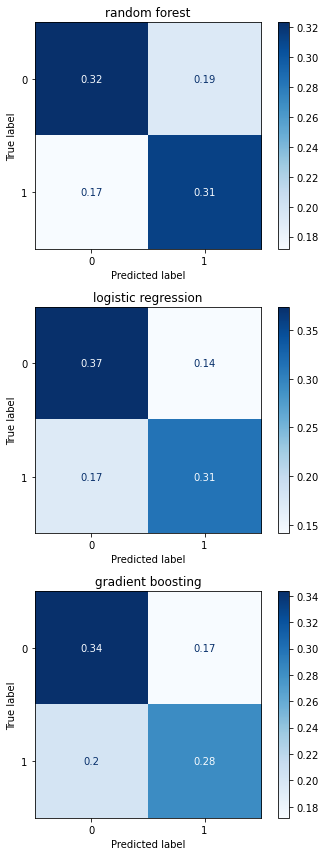

In [33]:
# plot the confusion matricies in a set of subplots
fig, (ax1, ax2, ax3) = plt.subplots(3,1,figsize=(5,12))
metrics.plot_confusion_matrix(model_rf, X_test, y_test, normalize='all', cmap='Blues', ax=ax1)
metrics.plot_confusion_matrix(model_log, X_test, y_test, normalize='all', cmap='Blues', ax=ax2)
metrics.plot_confusion_matrix(model_XG, X_test, y_test, normalize='all', cmap='Blues', ax=ax3)
ax1.set_title('random forest')
ax2.set_title('logistic regression')
ax3.set_title('gradient boosting')
fig.tight_layout()

#### Classification reports for all 3 models

In [34]:
# construct a data frame of classification report for the random forest model
report_rf_df = pd.DataFrame(metrics.classification_report(y_test, pred_rf, output_dict=True))
# construct a data frame of classification report of logistic regression model
report_log_df = pd.DataFrame(metrics.classification_report(y_test, pred_log, output_dict=True))
# construct a data frame of classification report of gradient boost model
report_XG_df = pd.DataFrame(metrics.classification_report(y_test, pred_XG, output_dict=True))


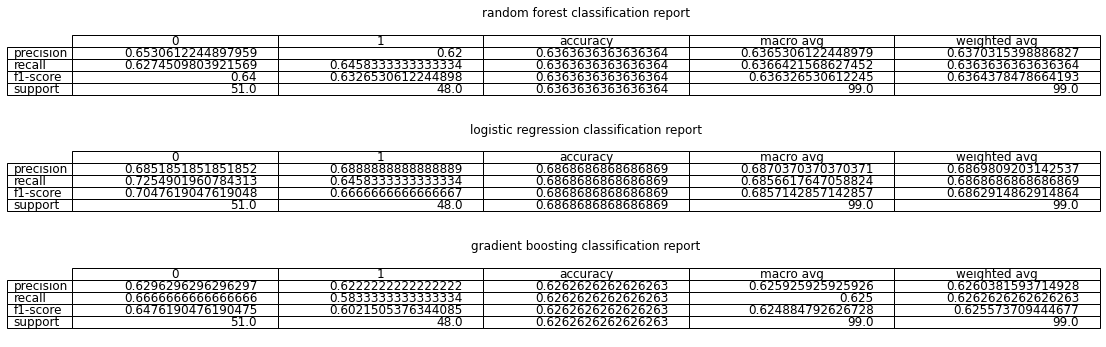

In [35]:
# label all classification reports and put them in a set of subplots
fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(15, 5))
fig.tight_layout()
table1 = ax1.table(cellText=report_rf_df.values,
          rowLabels=report_rf_df.index, 
          colLabels=report_rf_df.columns,
          loc="center"
         )
ax1.axis('off')
ax1.set_title('random forest classification report')
table1.set_fontsize(12)
table2 = ax2.table(cellText=report_log_df.values,
                  rowLabels=report_log_df.index,
                  colLabels=report_log_df.columns,
                  loc='center'
                  )
ax2.axis('off')
ax2.set_title('logistic regression classification report')
table2.set_fontsize(12)
table3 = ax3.table(cellText=report_XG_df.values,
                  rowLabels=report_XG_df.index,
                  colLabels=report_XG_df.columns,
                  loc='center'
                  )
ax3.axis('off')
ax3.set_title('gradient boosting classification report')
table3.set_fontsize(12)

#### Feature importance according to each model

In [36]:
# feature importance according to random forest model
rf_feature_imp = pd.DataFrame([X.columns, model_rf.feature_importances_]).T
rf_feature_imp.columns = ['feature', 'importance']
rf_feature_imp = rf_feature_imp.sort_values('importance', ascending=False)
rf_feature_imp

,feature,importance
0,p_agg_aggressive,0.215289
5,pot_size_large,0.191247
6,post_num_many,0.17776
1,f_agg_aggressive,0.16931
2,t_agg_aggressive,0.105425
4,vpip_tight,0.0972924
3,r_agg_aggressive,0.0436764


Text(0, 0.5, 'feature')

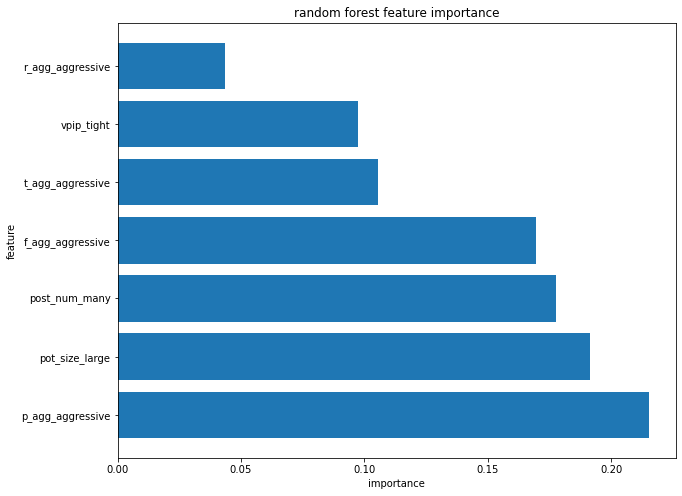

In [37]:
# plot feature importance according to the random forest model
plt.figure(figsize=(10,8))
plt.barh(rf_feature_imp['feature'], rf_feature_imp['importance'])
plt.title('random forest feature importance')
plt.xlabel('importance')
plt.ylabel('feature')

In [38]:
# feature importance of logistic regression model, represented by model coefficients
log_coef_df = pd.DataFrame([X.columns, model_log.coef_[0]]).T
log_coef_df.columns=['feature', 'coef']
log_coef_df = log_coef_df.sort_values('coef', ascending=False)
log_coef_df

,feature,coef
5,pot_size_large,0.670186
6,post_num_many,0.499743
4,vpip_tight,0.397298
3,r_agg_aggressive,-0.00548926
2,t_agg_aggressive,-0.394308
1,f_agg_aggressive,-0.545918
0,p_agg_aggressive,-0.658766


Text(0, 0.5, 'features')

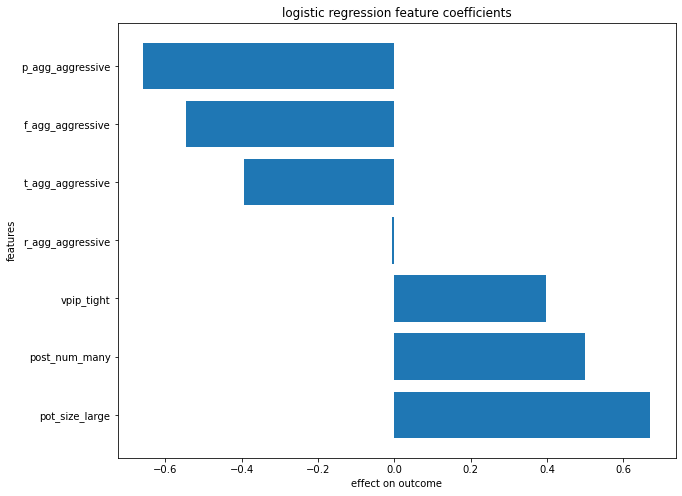

In [39]:
# plot feature coefficients according to the logistic regression model
plt.figure(figsize=(10,8))
plt.barh(log_coef_df['feature'], log_coef_df['coef'])
plt.title('logistic regression feature coefficients')
plt.xlabel('effect on outcome')
plt.ylabel('features')


In [40]:
# feature importance of gradient boosting model
XG_feature_imp = pd.DataFrame([X_train.columns,model_XG.feature_importances_]).T
XG_feature_imp.columns = ['feature', 'importance']
XG_feature_imp = XG_feature_imp.sort_values('importance', ascending=False)
XG_feature_imp

,feature,importance
0,p_agg_aggressive,0.206404
5,pot_size_large,0.16428
6,post_num_many,0.156685
2,t_agg_aggressive,0.138825
1,f_agg_aggressive,0.136689
4,vpip_tight,0.112426
3,r_agg_aggressive,0.0846902


Text(0, 0.5, 'feature')

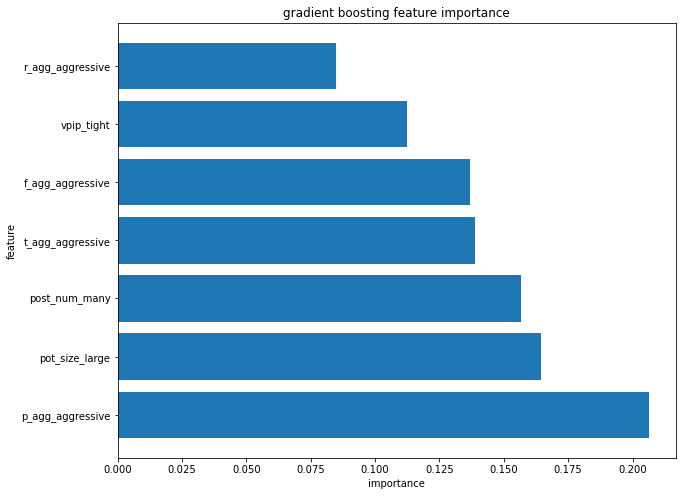

In [41]:
# plot feature importance according to the gradient boosting model
plt.figure(figsize=(10,8))
plt.barh(XG_feature_imp['feature'], XG_feature_imp['importance'])
plt.title('gradient boosting feature importance')
plt.xlabel('importance')
plt.ylabel('feature')

By comparing all 3 models, the logistic regression model has the best performance on both the training and testing data sets

### Regularize the features to reduce the complexity of the logistic regression model.

In [42]:
# initialize regularizer with the logisticregression model
reg = SelectFromModel(LogisticRegression(penalty='l1', C=C, solver='liblinear'))
reg.fit(X_train, y_train)
# observe the feature mask
feat_mask = reg.get_support()
feat_mask

array([ True,  True,  True, False,  True,  True,  True])

In [43]:
# observe the remaining features
feat = X_train.columns[feat_mask]
feat

Index(['p_agg_aggressive', 'f_agg_aggressive', 't_agg_aggressive',
       'vpip_tight', 'pot_size_large', 'post_num_many'],
      dtype='object')

The r_agg_aggressive column was eliminated by the regularizer, which makes sense because it was the least impactful according to the feature importance from all 3 models

The above regularization is done with C=0.1, which was found to be optimal from the earlier grid search. I will observe the feature importances given different values of C.

In [44]:
C_vals = [0.05, 0.06, 0.07, 0.08, 0.09, 0.1]
for c in C_vals:
    reg = SelectFromModel(LogisticRegression(penalty='l1', C=c, solver='liblinear'))
    reg.fit(X_train, y_train)
    feat_el = X_train.columns[~reg.get_support()]
    print(f'when C = {c}, {list(feat_el)} are eliminated from the X data frames')

when C = 0.05, ['f_agg_aggressive', 't_agg_aggressive', 'r_agg_aggressive', 'vpip_tight', 'pot_size_large'] are eliminated from the X data frames
when C = 0.06, ['f_agg_aggressive', 't_agg_aggressive', 'r_agg_aggressive', 'vpip_tight', 'pot_size_large'] are eliminated from the X data frames
when C = 0.07, ['t_agg_aggressive', 'r_agg_aggressive', 'vpip_tight'] are eliminated from the X data frames
when C = 0.08, ['t_agg_aggressive', 'r_agg_aggressive'] are eliminated from the X data frames
when C = 0.09, ['t_agg_aggressive', 'r_agg_aggressive'] are eliminated from the X data frames
when C = 0.1, ['r_agg_aggressive'] are eliminated from the X data frames


In [45]:
# update X_train and X_test with the new features when C = 0.1
X_train_reg = X_train[feat]
X_test_reg = X_test[feat]

In [46]:
# retrain and reevaluate the logistic regression model with the updated dataframes
model_log = LogisticRegression(penalty=pen, C=C)
model_log.fit(X_train_reg, y_train)
pred_log = model_log.predict(X_test_reg)
log_score = metrics.roc_auc_score(y_test, pred_log)
log_accuracy = metrics.accuracy_score(y_test, pred_log)
log_score, log_accuracy

(0.6856617647058824, 0.6868686868686869)

In [47]:
# create a summary table with tuned logistic regression
model_log_sm_t = sm.Logit(y_train, X_train_reg, C=0.1, penalty='l2').fit()
model_log_sm_t.summary()

Optimization terminated successfully.
         Current function value: 0.508094
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           win_per_hand   No. Observations:                  230
Model:                          Logit   Df Residuals:                      224
Method:                           MLE   Df Model:                            5
Date:                Thu, 17 Dec 2020   Pseudo R-squ.:                  0.2668
Time:                        22:33:34   Log-Likelihood:                -116.86
converged:                       True   LL-Null:                       -159.39
Covariance Type:            nonrobust   LLR p-value:                 7.331e-17
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
p_agg_aggressive    -1.2945      0.348     -3.715      0.000      -1.977      -0.612
f_agg_aggressive    -1.0420      0.359     -2.902      0.004      -1.746      -0.338
t_agg_aggressive    -0.6365      0.360     -1.767      0.077      -1.342       0.069
vpip_tight           0.6994      0.310      2.254      0.024       0.091       1.308
pot_size_large       1.5073      0.346      4.351      0.000       0.828       2.186
post_num_many        0.5289      0.343      1.544      0.123      -0.142       1.200
====================================================================================
"""

dropping the 'r_agg_aggressive' column didn't affect the performance of the model in any meaningful way

In [48]:
# update X_train and X_test with the new features when C = 0.07
X_train_reg = X_train.drop(['t_agg_aggressive', 'r_agg_aggressive', 'vpip_tight'], axis=1)
X_test_reg = X_test.drop(['t_agg_aggressive', 'r_agg_aggressive', 'vpip_tight'], axis=1)

In [49]:
# retrain and reevaluate the logistic regression model with the updated dataframes
model_log = LogisticRegression(penalty=pen, C=C)
model_log.fit(X_train_reg, y_train)
pred_log = model_log.predict(X_test_reg)
log_score = metrics.roc_auc_score(y_test, pred_log)
log_accuracy = metrics.accuracy_score(y_test, pred_log)
log_score, log_accuracy

(0.6770833333333335, 0.6767676767676768)

performance dropped a bit when I dropped 3 columns

According to the logistic regression model, an average recreational player should do the following for the best performance:
* play more large pots
* play in more multiway pots
* play less than 30% of hands
* play less aggressive post flop on all streets